In [1]:
import random
import numpy as np
import scipy.io.wavfile
import scipy.signal
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy #TODO what to import here?
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
import tensorflow as tf
from tensorflow.keras.layers import Dropout


class DataKeeper:
    def __init__(self):
        self.RawDatas = []
        self.RawLabel = []
    def AddNewType(self, data, label):
        self.RawDatas.append(data)
        self.RawLabel.append(label)
    
    @property
    def KeptTypeCount(self):
        return len(self.RawDatas)
    
    def GetData(self, index):
        return self.RawDatas[index]
    
    def GenerateTrainTestValid(self, alpha=0.8):
        #if aplha is 0.8 -> train is 80%, valid is 10%, test is 10%
        SumRawDatas = []
        #létrehozzuk a teljes adatállományt egy tömbben
        for x in range(0, len(self.RawDatas)):
            for element in self.RawDatas[x]:
                SumRawDatas.append([element,self.RawLabel[x]])
        #összekeverjük
        random.shuffle(SumRawDatas)
        #szétválogatjuk 3 részre
        train = SumRawDatas[:int(len(SumRawDatas)*alpha)]
        test_valid = SumRawDatas[int(len(SumRawDatas)*alpha):]
        test = test_valid[:int(len(test_valid)*0.5)]
        valid = test_valid[int(len(test_valid)*0.5):]
        
        #x_train, y_train létrehozása
        self.x_train = []
        self.y_train = []
        for x in train:
            self.x_train.append(x[0])
            self.y_train.append(x[1])
            
        #x_test, y_test létrehozása
        self.x_test = []
        self.y_test = []
        for x in test:
            self.x_test.append(x[0])
            self.y_test.append(x[1])
            
        #x_valid, y_valid létrehozása
        self.x_valid = []
        self.y_valid = []
        for x in valid:
            self.x_valid.append(x[0])
            self.y_valid.append(x[1])
            
        #numpy tömbbe konvertálás
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        
        self.x_valid = np.array(self.x_valid)
        self.y_valid = np.array(self.y_valid) 
        print("Kész")

In [2]:
def WavToSplittedArray(filename="", window_size = 100):
    fs, wave = scipy.io.wavfile.read(filename) 
    windows_count = int(len(wave)/window_size)

    kimenet = []
    for i in range(windows_count):
      buffer = []
      for x in range(window_size):
        buffer.append(wave[i*window_size+x])
      kimenet.append(buffer)
    return kimenet

In [3]:
ablakmeret = 1500

Adatgyujto = DataKeeper()

Adatgyujto.AddNewType(WavToSplittedArray("lada/monok/1lehuzva_mono.wav", ablakmeret), 0)
Adatgyujto.AddNewType(WavToSplittedArray("lada/monok/2lehuzva_mono.wav", ablakmeret), 1)
Adatgyujto.AddNewType(WavToSplittedArray("lada/monok/alapjarat_mono.wav", ablakmeret),2)


In [4]:
Adatgyujto.GenerateTrainTestValid()

Kész


In [5]:
hidden_layer_1_size = 50
hidden_layer_2_size = 30


tf.compat.v1.reset_default_graph() # It's good practice to clea and reset everything
clear_session            # even using Keras


# Model
#######

x = Input(shape=(ablakmeret,))

# Hidden layers

d0_layer = Dropout(.3)(x)

hidden_layer_1 = Dense(units=hidden_layer_1_size, activation="relu", kernel_regularizer="l2")(d0_layer)

d1_layer = Dropout(.3)(hidden_layer_1)
    
hidden_layer_2 = Dense(units=hidden_layer_2_size, activation="relu", kernel_regularizer="l2")(d1_layer)

d2_layer = Dropout(.3)(hidden_layer_2)
                        

    
# Softmax 

predictions = Dense(Adatgyujto.KeptTypeCount, activation="softmax")(d2_layer) #TODO: What activation?

# Full model

model = Model(inputs=x, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                75050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 93    

In [6]:
# Loss 

loss = sparse_categorical_crossentropy#TODO use the imported loss!

# Optimizer

optimizer = Adam() # A "smart" SGD variant 
 
# Compilation
#############

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) #TODO what to measure here?

history = model.fit(x=Adatgyujto.x_train, y=Adatgyujto.y_train,
                    validation_data=(Adatgyujto.x_valid, Adatgyujto.y_valid),
                    epochs=100,
                    batch_size=150)

Epoch 1/100
34/34 [==============================] - 1s 12ms/step - loss: 2156.2999 - accuracy: 0.5225 - val_loss: 687.0684 - val_accuracy: 0.6892
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 1322.6845 - accuracy: 0.5664 - val_loss: 375.9835 - val_accuracy: 0.7012
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 931.9919 - accuracy: 0.5749 - val_loss: 254.7437 - val_accuracy: 0.7022
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 665.2273 - accuracy: 0.5674 - val_loss: 170.3468 - val_accuracy: 0.6982
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 480.3198 - accuracy: 0.5787 - val_loss: 110.3717 - val_accuracy: 0.6820
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 362.9628 - accuracy: 0.5749 - val_loss: 72.1453 - val_accuracy: 0.6683
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 252.1624 - accuracy: 0.5795 - val_loss: 43.4414 - val_a

In [21]:
predikalando = 10

pred = model.predict(Adatgyujto.x_test[predikalando].reshape(1,ablakmeret))

print("ennek kene hogy legyen: " + str(Adatgyujto.y_test[predikalando]))
pred

ennek kene hogy legyen: 2


array([[0.14811009, 0.14734435, 0.7045456 ]], dtype=float32)

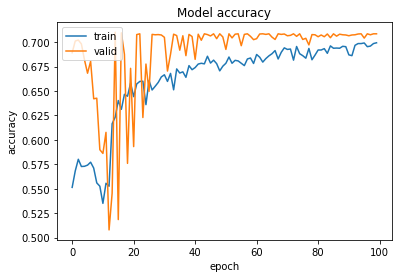

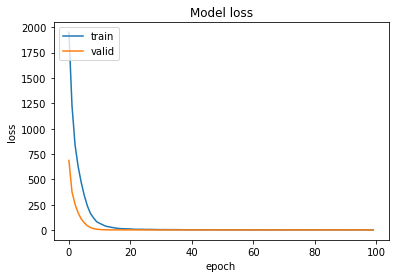

In [7]:
import matplotlib.pyplot as plt

def display_history(history):
    plt.plot(history.history['accuracy']) #TODO what to measure here for training?
    plt.plot(history.history['val_accuracy']) #TODO what to measure here for validation?
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history)

In [8]:
model.save("KerasModels/SimpleDenseNet.h5")